In [1]:
 # !pip install numpy pandas matplotlib datetime seaborn pyarrow transformers scikit-learn

In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import seaborn as sns

import os
import random
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.profiler import profile, record_function, ProfilerActivity

from os import listdir

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(20020109)

text_data_dir = "./text_data/"
num_train_dir =  "./num_aggregated_data/"


cuda


In [3]:

class TrainDataset(Dataset):
    def __init__ (self, shortterm_input_seq_len, longterm_input_seq_len, output_seq_len, noise_factor, ):
        self.df = pd.concat([pd.read_pickle(num_train_dir + "train2"),pd.read_pickle(num_train_dir + "test2")], axis=0)
        print("loaded train df shape: ", self.df.shape)

        self.shortterm_input_seq_len = shortterm_input_seq_len
        self.longterm_input_seq_len = longterm_input_seq_len
        self.output_seq_len = output_seq_len
        self.noise_factor = noise_factor
        self.min_idx = longterm_input_seq_len
        self.max_idx = 7200 - self.output_seq_len # just value for train test split

        self.dates = self.df["Date"]
        # remove dates column because it cant be a tensor
        self.df = self.df.drop(columns=['Date'])
        self.colnames = self.df.columns
        # convert to float tensor
        self.datatensor = torch.tensor(self.df.values).float()
        # apply differencing to detrend the data
        self.processedtensor = self.difference(self.datatensor)
        # calculate macd to add to data
        macd_line, signal_line = self.calculate_macd(self.datatensor[:,:4])
        rsi = self.calculate_rsi(self.datatensor[:,0]).unsqueeze(1)
        # add macd and signal line to data
        self.processedtensor = torch.cat([self.processedtensor, macd_line, signal_line, rsi], dim=1)

        print("processed data tensor shape: ", self.processedtensor.shape)
           
    def __len__(self):
        return self.max_idx - self.min_idx
    def __getitem__(self, index):
        # since length is given as maxidx - minidx, the true index actually needs to + minidx
        index = self.min_idx + index
        # get "today"
        index_day = self.dates[index]
        # save initial value of today, only used for inferencing
        initial_value = self.datatensor[index,:] 

        # gather previous days of numerical data
        segment = self.processedtensor[index-self.longterm_input_seq_len: index+self.output_seq_len]
        # fit scaler using just the input portion, but scale everything including the target
        segment,mean,std = self.standard_scale(segment, self.longterm_input_seq_len)

        # longterm numeric input, add noise 
        lnumin = segment[1:self.longterm_input_seq_len+1,:]
        # lnumin = lnumin + torch.randn(lnumin.size()) * self.noise_factor
        # shortterm numeric input add noise
        snumin = segment[self.longterm_input_seq_len - self.shortterm_input_seq_len + 1: self.longterm_input_seq_len+1, :]
        # snumin = snumin + torch.randn(snumin.size()) * self.noise_factor
        # target, convert to tensor
        numout = segment[self.longterm_input_seq_len:,:]

        # the sample with extra data is for inferencing
        sample = {"lnumin":lnumin, "snumin":snumin, "numout": numout,"colnames": self.colnames,"mean": mean, "std":std, "startday": index_day, "initial_value":initial_value}
        # sample = {"lnumin":lnumin, "snumin":snumin, "numout": numout}

        return sample
    
    def ema(self, data, period=12, smooth=2):
        alpha = smooth / (1 + period)
        ema = torch.zeros_like(data)
        ema[0,:] = data[0,:]  # Assuming data[0] is the oldest value
        for t in range(1, len(data)):
            ema[t,:] = alpha * data[t,:] + (1 - alpha) * ema[t - 1,:]
        return ema

    def calculate_macd(self, data):
        ema12 = self.ema(data, period=12)
        ema26 = self.ema(data, period=26)
        macd_line = ema12 - ema26
        signal_line = self.ema(macd_line, period=9)
        return macd_line, signal_line
    
    def calculate_rsi(self, data, periods=14):
        # Calculate the difference between consecutive days
        delta = data[1:] - data[:-1]
        # Initialize gains and losses tensors
        gains = torch.zeros_like(delta)
        losses = torch.zeros_like(delta)
        # Calculate gains (where delta > 0) and losses (where delta < 0)
        gains[delta > 0] = delta[delta > 0]
        losses[delta < 0] = -delta[delta < 0]
        # Calculate the average gains and losses
        avg_gain = torch.zeros_like(data)
        avg_loss = torch.zeros_like(data)
        for i in range(periods, len(data)):
            if i == periods:
                avg_gain[i] = gains[:i].mean(dim=0)
                avg_loss[i] = losses[:i].mean(dim=0)
            else:
                avg_gain[i] = (avg_gain[i-1] * (periods - 1) + gains[i-1]) / periods
                avg_loss[i] = (avg_loss[i-1] * (periods - 1) + losses[i-1]) / periods
        # Avoid division by zero
        avg_loss[avg_loss == 0] = 1e-10
        # Calculate the Relative Strength (RS)
        rs = avg_gain / avg_loss
        # Calculate the RSI
        rsi = 100 - (100 / (1 + rs))
        # Pad the first 'periods' with zeros as RSI is not defined for them
        rsi[:periods] = 0
        return rsi

    def difference(self, x):
        # Calculate differences along the sequence dimension (assuming x is of shape [seq_len, features])
        differences = x[1:, :] - x[:-1, :]
        # Prepend zeros at the beginning of the sequence dimension
        zeros = torch.zeros((1, x.shape[1]), dtype=x.dtype)
        differences_padded = torch.cat([zeros, differences], dim=0)
        return differences_padded
    
    def standard_scale(self, segment, longterm_input_seq_len):        
        # Extract the input portion used for calculating scaling parameters
        input_portion = segment[1:longterm_input_seq_len+1, :]
        # Calculate the mean and standard deviation of the input portion
        mean = torch.mean(input_portion, dim=0, keepdim=True)
        std = torch.std(input_portion, dim=0, unbiased=False, keepdim=True)
        # Ensure std is not zero to avoid division by zero
        std = torch.where(std == 0, torch.ones_like(std), std)
        # Scale the entire segment
        scaled_segment = (segment - mean) / std
        return scaled_segment, mean, std

In [4]:
class LFeatureExtractor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # since numeric data has patterns and cycles, use convolution and pooling to capture those patterns, and generate embeddings for later use
        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size=4, stride=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(64, 128, kernel_size=4, stride=2)
        self.relu2 = nn.ReLU()
        self.conv4 = nn.Conv1d(128, out_channels, kernel_size=8,stride=4)
        self.relu4 = nn.ReLU()
        self.maxpool = nn.MaxPool1d(4,2,padding=2)
        self.bn = nn.BatchNorm1d(out_channels)
    def forward(self, x):
        x = torch.permute(x, [0,2,1]).contiguous() # conv operations need a different shape than linear, this will be undoed later
        a = self.conv1(x)
        a = self.relu1(a)
        a = self.conv2(a)
        a = self.relu2(a)
        a = self.conv4(a)
        a = self.relu4(a)
        a = self.maxpool(a)
        a = self.bn(a)
        # print(a.shape)
        return a

class SFeatureExtractor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, bidirectional=True):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=bidirectional)
    def forward(self, x):
        output, (hn, cn) = self.lstm(x)
        # print(output.shape)
        return output

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [6]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))
    
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, num_heads, batch_first=True)
        self.cross_attn = nn.MultiheadAttention(d_model, num_heads, batch_first=True)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, snumin, lnumin):
        attn_output, _ = self.self_attn(snumin, snumin, snumin)
        snumin = self.norm1(snumin + self.dropout(attn_output))
        attn_output, _ = self.cross_attn(snumin, lnumin, lnumin)
        snumin = self.norm2(snumin + self.dropout(attn_output))
        ff_output = self.feed_forward(snumin)
        snumin = self.norm3(snumin + self.dropout(ff_output))
        return snumin
    
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, num_heads, batch_first=True)
        self.cross_attn = nn.MultiheadAttention(d_model, num_heads, batch_first=True)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_output, mask = None):
        attn_output, _ = self.self_attn(x, x, x, attn_mask=mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output, _ = self.cross_attn(x, enc_output, enc_output)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

class PredictBlock(nn.Module): 
    def __init__(self, in_channels, out_channels, dropout_rate=0.1):
        super().__init__()
        self.linear1 = nn.Linear(in_channels, 256)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(128, 64)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)  # Initialize dropout with the passed rate
        self.linear4 = nn.Linear(64, out_channels)
        
    def forward(self, x):
        a = self.linear1(x)
        a = self.relu1(a)
        a = self.linear2(a)
        a = self.relu2(a)
        a = self.linear3(a)
        a = self.relu3(a)
        a = self.dropout(a)  # Apply dropout after activation
        a = self.linear4(a)
        return a

In [7]:
class Transformer(nn.Module):
    def __init__(self, input_size, input_max_len, d_model, num_heads, num_layers, d_ff, dropout):
        super(Transformer, self).__init__()

        self.longfeat = LFeatureExtractor(input_size, d_model)
        self.shortfeat = SFeatureExtractor(input_size, d_model // 2, num_layers)
        self.outfeat = SFeatureExtractor(input_size, d_model, num_layers,bidirectional=False)
        self.posen = PositionalEncoding(d_model, input_max_len)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.pred = PredictBlock(d_model, input_size, dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, snumin, lnumin, target, causal = True):
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(target.shape[1], device=device)
        # print(tgt_mask.shape)
        snumin_embedded = self.dropout(self.posen(self.shortfeat(snumin)))
        lnumin_embedded = self.dropout(self.posen(torch.permute(self.longfeat(lnumin), [0,2,1])))
        tgt_embedded = self.dropout(self.posen(self.outfeat(target)))
        # print(snumin_embedded.shape, lnumin_embedded.shape, tgt_embedded.shape)
        enc_output = snumin_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, lnumin_embedded)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            if causal:
                dec_output = dec_layer(dec_output, enc_output, tgt_mask)
            else:
                dec_output = dec_layer(dec_output, enc_output, None)

        output = self.pred(dec_output)
        return output

In [8]:
class Loss(nn.Module):
    def __init__(self, overprediction_penalty=1.5, underprediction_penalty=1.0, alpha = 0.5, beta = 0.5):

        super().__init__()
        self.mae = nn.L1Loss()
        self.alpha = alpha
        self.beta = beta
        self.overprediction_penalty = overprediction_penalty
        self.underprediction_penalty = underprediction_penalty

    def forward(self, predictions, targets):
        # loss for all none derivative features except sp500 stuff
        sp500_excluded_loss = self.mae(predictions[:,:,4:15], targets[:,:,4:15])
        # loss for sp500 stuff with more penalty for being too bullish
        errors = predictions[:,:,:4] - targets[:,:,:4]
        overprediction_errors = torch.where(errors > 0, errors, torch.zeros_like(errors))
        underprediction_errors = torch.where(errors < 0, -errors, torch.zeros_like(errors))
        sp500_loss = self.overprediction_penalty * overprediction_errors.mean() + self.underprediction_penalty * underprediction_errors.mean()
        # cumulated loss to punish long term inaccuracy and stuborness
        cumulative_errors = torch.cumsum(errors, dim=1)
        cumulative_loss = torch.mean(torch.abs(cumulative_errors))

        return (1 - self.alpha) * sp500_excluded_loss + self.alpha * sp500_loss + self.beta * cumulative_loss

    
class Saver():
    def __init__(self) -> None:
        self.date = datetime.strftime(datetime.utcnow(), "%m-%d-%Y %H-%M-%S")
        self.save_dir = f"./train_saves/ {str(self.date)}"
        if not os.path.exists(str(self.date)):
            os.makedirs(self.save_dir, exist_ok=True)
        self.progresspath = self.save_dir+"/progress.txt"

    def save_transformer_weights(self, state_dict, epoch_num:int):
        fpath = self.save_dir + f"/model_at_epoch_{str(epoch_num)}.pt"
        torch.save(state_dict, fpath)
        return None
    def save_transformer_weights_it(self, state_dict, epoch_num:int, len):
        fpath = self.save_dir + f"/iterative{str(len)}_at_epoch_{str(epoch_num)}.pt"
        torch.save(state_dict, fpath)
        return None
    def save_transformer_weights_direct_it(self, state_dict, epoch_num:int, len):
        fpath = self.save_dir + f"/directiterative{str(len)}_at_epoch_{str(epoch_num)}.pt"
        torch.save(state_dict, fpath)
        return None
    def save_transformer_weights_it_refine(self, state_dict, epoch_num:int, len):
        fpath = self.save_dir + f"/it_refine days{str(len)}_at_epoch_{str(epoch_num)}.pt"
        torch.save(state_dict, fpath)
        return None
saver = Saver()

In [9]:
batch_size = 32*4
learning_rate = 0.0002
noise_factor = 0.1
dropout = 0.2
longterm_input_seq_len = 1024 
shortterm_input_seq_len = 384
output_seq_len = 64 # number of targets we predict
input_size = 15 + 9
d_model = 256
num_heads = 8
num_layers = 4
d_ff = 2048
max_seq_length = longterm_input_seq_len

trainset = TrainDataset(shortterm_input_seq_len, longterm_input_seq_len, output_seq_len, noise_factor)
print(trainset.min_idx, trainset.max_idx, trainset.__len__())
dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True,num_workers=8)
crit = Loss()


loaded train df shape:  (7805, 16)


processed data tensor shape:  torch.Size([7805, 24])
1024 7136 6112


In [10]:
# # autoregressive training
# model = Transformer(input_size, longterm_input_seq_len, d_model, num_heads, num_layers, d_ff, dropout)
# model = nn.DataParallel(model)
# model.to('cuda')
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# print("total parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad)) 

# for j in range(0,200):
#     epochloss = 0
#     num_batches = 0
#     for i, batch in enumerate(dataloader):
#         # get data
#         snumin = batch["snumin"].to(device)
#         lnumin = batch["lnumin"].to(device)
#         numout = batch["numout"].to(device)

#         # print(snumin.shape, lnumin.shape, numout.shape)
#         # get predictions
#         decoderin = torch.zeros(batch_size, output_seq_len, num_numeric_features).to(device)
#         decoderin[:,0,:] = numout[:,0,:]

#         # get predictions
#         total_loss = 0
#         for d in range(output_seq_len - 1):
#             preds = model(snumin, lnumin, decoderin)
#             pred = preds[:,d,:] # only take the next days prediction
#             target = numout[:,d+1,:]
#             loss = crit(pred.unsqueeze(1), target.unsqueeze(1))
#             # back prop
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
            
#             decoderin[:,d+1,:] = pred.detach()

#         target = numout[:,1:,:]
#         res = decoderin[:,1:,:] # start from the 1st day because the 0th day is not predicted by model
#         loss = crit(res, target)
#         losspretty = loss.item()
#         epochloss += losspretty
#         num_batches += 1
        
#         with open(saver.progresspath,'a') as file:
#             file.write(" ---  it batch: " + str(i) + " loss: " + str(losspretty) +"\n")
#         print("--- it batch : ", i, "  loss: ", losspretty)
        
#     with open(saver.progresspath,'a') as file:
#         file.write("it epoch done: " + str(j) + "    avg loss: " + str(epochloss / num_batches) +"\n")
#     print("it epoch done: ", j, "  avg loss in epoch: ", epochloss / num_batches)
#     if (j+1) % 50 == 0:
#         saver.save_transformer_weights(model.module.state_dict(), j)


In [11]:
# # teacher forcing training
# model = Transformer(input_size, longterm_input_seq_len, d_model, num_heads, num_layers, d_ff, dropout)
# model = nn.DataParallel(model)
# model.to('cuda')
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# print("total parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad)) 

# # set epoch manually, this changes flexibly
# for j in range(0,200):
#     epochloss = 0
#     num_batches = 0
#     for i, batch in enumerate(dataloader):
#         # get data
#         snumin = batch["snumin"].to(device)
#         lnumin = batch["lnumin"].to(device)
#         numout = batch["numout"].to(device)

#         # print(snumin.shape, lnumin.shape, numout.shape)
#         # get predictions
#         preds = model(snumin, lnumin, numout)
#         # calculate loss, at each day i we are predicting day i+1, so the target will be the original input shifted left by 1 time step 
#         res = preds[:,:-1,:] # truncate the last element of the pred because we dont have the ground truth of day seqlength + 1 to compare against it
#         target = numout[:,1:,:] # start from the 1st day because the 0th day is not predicted by model
#         loss = crit(res, target)
#         # back prop
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         losspretty = loss.item()
#         epochloss += losspretty
#         num_batches += 1
#         with open(saver.progresspath,'a') as file:
#             file.write(" --- batch: " + str(i) + " loss: " + str(losspretty) +"\n")
#         print("--- batch : ", i, "  loss: ", losspretty)
#     with open(saver.progresspath,'a') as file:
#         file.write("next day epoch done: " + str(j) + "    avg loss: " + str(epochloss / num_batches) +"\n")
#     print("next day epoch done: ", j, "  avg loss in epoch: ", epochloss / num_batches)
#     if (j+1) % 50 == 0:
#         saver.save_transformer_weights(model.module.state_dict(), j)

    

In [12]:
# # direct multiday training
# model = Transformer(input_size, longterm_input_seq_len, d_model, num_heads, num_layers, d_ff, dropout)
# # state_dict = torch.load('train_saves/ 02-11-2024 00-56-45/model_at_epoch_199.pt')
# # model.load_state_dict(state_dict)
# model = nn.DataParallel(model)
# model.to('cuda')
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# print("total parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad)) 

# for j in range(0,200):
#     epochloss = 0
#     num_batches = 0
#     for i, batch in enumerate(dataloader):
#         # get data
#         snumin = batch["snumin"].to(device)
#         lnumin = batch["lnumin"].to(device)
#         numout = batch["numout"].to(device)
#         # print(snumin.shape, lnumin.shape, numout.shape)

#         # get predictions
#         decoderin = snumin[:,-output_seq_len:,:]
#         preds = model(snumin, lnumin, numout, causal = False)
        
#         # calculate loss, at each day i we are predicting day i+1, so the target will be the original input shifted left by 1 time step 
#         res = preds[:,:-1,:] # truncate the last element of the pred because we dont have the ground truth of day seqlength + 1 to compare against it
#         target = numout[:,1:,:] # start from the 1st day because the 0th day is not predicted by model
#         loss = crit(res, target)
#         # back prop
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         losspretty = loss.item()
#         epochloss += losspretty
#         num_batches += 1
        
#         with open(saver.progresspath,'a') as file:
#             file.write(" ---  direct batch: " + str(i) + " loss: " + str(losspretty) +"\n")
#         print("--- direct batch : ", i, "  loss: ", losspretty)
        
#     with open(saver.progresspath,'a') as file:
#         file.write("direct epoch done: " + str(j) + "    avg loss: " + str(epochloss / num_batches) +"\n")
#     print("direct epoch done: ", j, "  avg loss in epoch: ", epochloss / num_batches)
    
#     if (j+1) % 50 == 0:
#         saver.save_transformer_weights(model.module.state_dict(), j)


1997-02-18 00:00:00
torch.Size([63, 4]) torch.Size([4]) torch.Size([4])
----% :  5.708885192871094
1997-03-04 00:00:00
torch.Size([63, 4]) torch.Size([4]) torch.Size([4])
----% :  2.7465338706970215
1997-03-18 00:00:00
torch.Size([63, 4]) torch.Size([4]) torch.Size([4])
----% :  5.476808547973633
1997-04-02 00:00:00
torch.Size([63, 4]) torch.Size([4]) torch.Size([4])
----% :  4.743234157562256
1997-04-16 00:00:00
torch.Size([63, 4]) torch.Size([4]) torch.Size([4])
----% :  8.689274787902832
1997-04-30 00:00:00
torch.Size([63, 4]) torch.Size([4]) torch.Size([4])
----% :  7.071027755737305
1997-05-14 00:00:00
torch.Size([63, 4]) torch.Size([4]) torch.Size([4])
----% :  7.6555399894714355
1997-05-29 00:00:00
torch.Size([63, 4]) torch.Size([4]) torch.Size([4])
----% :  7.43955135345459
1997-06-12 00:00:00
torch.Size([63, 4]) torch.Size([4]) torch.Size([4])
----% :  4.695456504821777
1997-06-26 00:00:00
torch.Size([63, 4]) torch.Size([4]) torch.Size([4])
----% :  4.916354179382324
1997-07-1

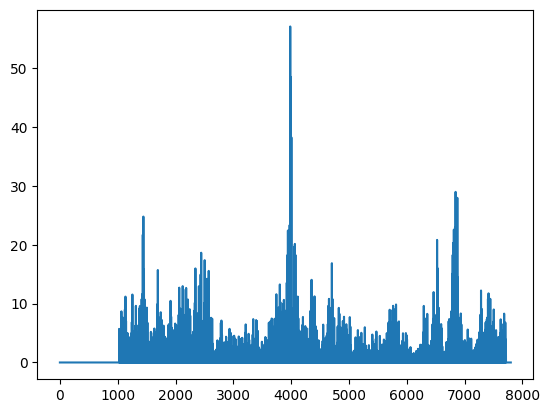

tensor(0.4827)


In [63]:
### inference
model = Transformer(input_size, longterm_input_seq_len, d_model, num_heads, num_layers, d_ff, dropout)
state_dict = torch.load('good/model_at_epoch_999.pt')
model.load_state_dict(state_dict)
model.eval()
model = nn.DataParallel(model)
model.to('cuda')

def inverse_transform(x, mean, std, initial_value):
    og = x * std + mean
    og = og.cumsum(axis=0) + initial_value
    return og

def percent_diff(x, y):
    # Calculate the absolute difference
    absolute_difference = torch.abs(y - x)
    # Calculate the average of the two tensors
    avg = (x + y) / 2
    # Avoid division by zero by adding a small value, epsilon
    epsilon = 1e-8
    avg += epsilon
    # Calculate percent difference
    return (absolute_difference / avg) * 100

totaldiff = torch.zeros(7800)

for d in range(0, 6700,10):
    # for day in range(5200,5700,5):
    batch = trainset.__getitem__(d)
    # today (last day we have access to)
    startday = batch["startday"]
    print(startday)
    # get vars needed to undo transform and scaling
    mean = batch["mean"][0,:4]
    std = batch["std"][0,:4]
    initial_value = batch["initial_value"][:4]
    # get model input and target
    snumin = batch["snumin"].to(device).unsqueeze(0)
    lnumin = batch["lnumin"].to(device).unsqueeze(0)
    numout = batch["numout"].to(device).unsqueeze(0)

    # prepare input to decoder
    decoderin = snumin[:,-output_seq_len:,:]
    preds = model(snumin, lnumin, decoderin, causal = False)

    # inverse transform predictions
    preds = preds[0][:-1,:4].detach().cpu()
    print(preds.shape, mean.shape, std.shape)
    preds = inverse_transform(preds, mean, std, initial_value)
    # get original values for ground truth
    truth = numout[0][1:,:4].detach().cpu()
    truth = inverse_transform(truth, mean, std, initial_value)

    # plot
    # plt.plot(range(1, preds.shape[0] + 1), preds[:,0])
    # plt.plot(range(1, truth.shape[0] + 1), truth[:,0])
    # plt.legend(("predicted spy", "true spy"))
    # plt.ylim(350,550)
    # plt.show()

    # get percent diff
    diff = percent_diff(preds, truth)
    diff = torch.mean(diff).item()
    print("----% : ", diff)
    totaldiff[1024 + d] = diff

plt.plot(range(totaldiff.size(0)), totaldiff)
plt.show()
print(torch.mean(totaldiff))
